<u><center><font size=7> Contact matrix </font></center></u>
<center> This program will identify pairs of peptides and calculate a residue-residue contact matrix </center>

<b>Algorithm steps:</b> 

 <ul>
  <li>Find pairs of peptides that have atoms within a minimum distance of 6 angstrom</li>
  <li>Take pair of peptides and calculate residue by residue minimum distance </li>
  <li>If multiple aggregates are present, take the minimum distance for each residue:residue contact</li>
</ul> 

<b>Directions:</b> 

 <ul>
  <li>Fill out dictionary in cell 4</li>
  <li>Run all cells </li>
</ul> 



<b>Future developments:</b> 

 <ul>
  <li>Adapt for hetrogenous aggregates in synergy simulations</li>
  <li> Add functions for non-protenogenic molecules </li>
  <li>Consider Free energy calculations between residues of interst</li>
</ul> 

In [119]:
import MDAnalysis
from MDAnalysis import analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 


In [3]:
### Number of peptides ####
##gromacs configuration file###
gro_file = 'fullsys.gro'
##compressed trajectory file###
trajectory_file = 'complete_final.xtc'
u = MDAnalysis.Universe('%s'%gro_file, '%s'%trajectory_file)
##### Sim start and sim end time
start = 0 
end = 200

In [4]:
################################# INSERT INFO FOR PEPTIDE1 ##########################################
peptide = dict()
#### Single letter sequence #####
peptide['sequence'] = 'LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES'
#### Peptide name #####
peptide['peptide_name'] = 'LL-37'
#### Number of peptides #####
peptide['pepnum'] = 4
### DO NOT EDIT ###
peptide['resnum'] = len(peptide['sequence'])
peptide['restot'] = peptide['pepnum']*peptide['resnum']
peptide['starting_resid'] = 1

In [5]:
#create dictionary of amino acids 
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HSP': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
#invert to permit single letter to be entered
inv_map = {v: k for k, v in d.items()}
#create function to generate 3 letter code with residue position
def single_three(sequence,resnum):
    single = (list(sequence)) 
    Aminos=[]
    for i in range(0,(resnum)):
        value = single[i]
        Aminos.append((str(i+1))+inv_map[value])
    return Aminos
peptide['Aminos'] = single_three(peptide['sequence'],peptide['resnum'])

In [69]:
#Select peptides - Test with combinations of peptides with different sizes (should work though!!)
def select_peptides(peptide):
    peptide_selections = []
    for i in range(0,peptide['pepnum']):
        start = (i*peptide['resnum']) + peptide['starting_resid']
        end = (i+1)*peptide['resnum'] + (peptide['starting_resid']-1)
        selection = "resid %s"%start + ":%s"%end
        peptide_selections.append(selection)
    return peptide_selections
peptide_selections = select_peptides(peptide)

In [70]:
def find_pairs(peptide):
    import MDAnalysis.analysis.distances
    peptide_selections = select_peptides(peptide)
    pair_list=[]
    for ts in u.trajectory[-1:]:
        for i in range(0,len(peptide_selections)):
            #loop through second iterator
            for j in range(i,len(peptide_selections)):
                if i != j:
                    #Selection and distasnce calculation
                    selection1 = u.select_atoms('%s'%peptide_selections[i]).positions
                    selection2 = u.select_atoms('%s'%peptide_selections[j]).positions
                    dist = MDAnalysis.analysis.distances.distance_array(selection1, selection2, 
                                                                        box=None, result=None, backend='serial')
                    ##Shoudl this be min or mean? 
                    min_dist = np.min(dist)
                    #Apply cut off of 6 angstrom - could this be stratified better?
                    if min_dist < 6:
                        pair_list.append([i,j])
    return pair_list
peptide_pairs = find_pairs(peptide)

In [99]:
def distance_matrix(peptide):
    import itertools
    mindist_matrix_all=[]
    mindist_matrix_average =[]
    #works same as nested loop
    for ts in u.trajectory[-1:]:
        for i,j in peptide_pairs:
            test1 =[]
            #Create lists of residues for pairs
            pair_residues_1= np.arange(((i*peptide['resnum']) + peptide['starting_resid']),(
                (i+1)*peptide['resnum'] + (peptide['starting_resid'])))
            pair_residues_2= np.arange(((j*peptide['resnum']) + peptide['starting_resid']),(
                (j+1)*peptide['resnum'] + (peptide['starting_resid'])))
            #use itertools to make all permutations 
            combinations = list(itertools.product(pair_residues_1, pair_residues_2))

            #Loop through permutations, create 2D array with amino acid and minimum distance
            mindist_matrix_all_peptide = []
            mindist_matrix_average_peptide = []
            for combination in combinations:
                selection1 = u.select_atoms('resid %s'%combination[0]).positions
                selection2 = u.select_atoms('resid %s'%combination[1]).positions
                dist = MDAnalysis.analysis.distances.distance_array(selection1, selection2, 
                                                                    box=None, result=None, backend='serial')
                min_dist = np.min(dist)
                AA_1 = peptide['Aminos'][(combination[0]-combinations[0][0])]
                AA_2 = peptide['Aminos'][(combination[1]-combinations[0][1])]
                mindist_matrix_all_peptide.append([AA_1,AA_2,min_dist])
                mindist_matrix_average_peptide.append(min_dist)
                
            #Take residue names from the final list of all peptides --- will this work for synergy???
            #Convert to array first to permit slicing out of subaxis
            mindist_matrix_average.append(mindist_matrix_average_peptide)
            #Combine all pairs into one index
            mindist_matrix_all.append(mindist_matrix_all)
        #pull pair names out from array of all combinations    
        names = np.array(mindist_matrix_all_peptide)
        #Take the minimum accross peptides ---rename average variables as they are misleading
        mindist_matrix_average_out = np.column_stack((np.min(mindist_matrix_average,
                                                   axis=0),list(names[:,0]),list(names[:,1])))
        return mindist_matrix_average_out

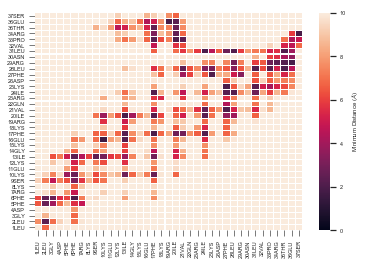

In [118]:
def plot_matrix(peptide):
    #Call calculating functio, add to dataframe
    df = pd.DataFrame(distance_matrix(peptide))
    df.columns = ['mindist', 'Peptide1','Peptide2']
    df['mindist'] = df['mindist'].astype(float)
    #pviot for heatmap
    df = df.pivot(index='Peptide1', columns='Peptide2', values='mindist')
    #reorder from 1 to X
    df = df.reindex(columns=peptide['Aminos'],index=peptide['Aminos'])
    df = df.reset_index()
    df['Section_Number'] = df['Peptide1'].str.replace('([A-Z]+)', '').astype(float)
    df = df.sort_values('Section_Number',ascending=False)
    df = df.drop('Section_Number',1)
    df = df.set_index('Peptide1')
    #Plot heatmap, consider nicer colormap
    #Adjust scale depending on number of residues -- automate??
    sns.set(font_scale=0.5)
    ax = sns.heatmap(df,vmin=0,vmax=10,linewidths=.05,cbar_kws={'label': 'Minimum Distance ($\AA$)'})
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.tick_params(
    which='both', 
    width = 0.6,
    bottom=True,
    left=True,
    labelbottom=True) 
    plt.savefig('contact_matrix_%s'%peptide['peptide_name'],dpi=300,bbox_inches="tight")
plot_matrix(peptide)